# **UNICEF Indicator Data Warehouse** - SDMX REST API Web Service

In [379]:
# import necessary libraries 
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

Connecting to the UNICEFs data warehouse using the SDMX standard

In [380]:
endpoint = "https://sdmx.data.unicef.org/ws/public/sdmxapi/rest"

### **1. STEP: select a dataflow**

Dataflows contain a set of data within a common structure. So I use the API to get a list of all those dataflows first. 

This requires adding the following to the endpoint and providing the parameters for ```format```, ```detail``` and ```reference```. I chose to get the data in the **JSON format**, with **full detail** and **no references**. 

In [381]:
dataflow_endpoint = "/dataflow/all/all/latest"
dataflow_params = {
    "format": "sdmx-json",
    "detail": "full",
    "reference": "none",
}

In [382]:
# get the response and checking the status code 
dataflow_response = requests.get(url=endpoint+dataflow_endpoint, params=dataflow_params)
print(dataflow_response.status_code)

# converting the response into JSON format, printing the response 
# I arrived at the final printing format by following and trying out different keys  
dataflows = dataflow_response.json()['data']['dataflows']
for dflow in dataflows:
    # getting the "id" will be necessary for the next API call
    print(f"name: {dflow['name']} - id: {dflow['id']} - agency-id: {dflow['agencyID']} - dataflow-version: {dflow['version']}")

200
name: Brazil Country Office - id: BRAZIL_CO - agency-id: BRAZIL_CO - dataflow-version: 1.0
name: Brazil SELO - id: BRAZIL_CO_SELO - agency-id: BRAZIL_CO - dataflow-version: 1.0
name: CAP 2030 - id: CAP2030 - agency-id: CAP2030 - dataflow-version: 1.0
name: Coundown 2030 - id: CD2030 - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - coverage indicators - id: CDCOV - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - demographic indicators - id: CDDEM - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - drivers indicators - id: CDDRIVER - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - coverage - equiplot data - id: CDEQUIPLOT - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - tier 2 indicators - id: CDT2 - agency-id: CD2030 - dataflow-version: 1.0
name: CD2030 All - id: CONSOLIDATED - agency-id: CD2030 - dataflow-version: 1.0
name: EAPRO Cross Sector Indicators - id: DF_EAPRO_CROSS_SECTOR - agency-id: EAPRO - dataflow-version: 1.0

I chose  ```name: Demography - id: DM - agency-id: UNICEF - dataflow-version: 1.0```  for further exploration.

In [383]:
SELECTED_DFLOW = 'DEMOGRAPHY'
SELECTED_DFLOW_ID = 'DM'
SELECTED_AGENCY_ID = 'UNICEF'
SELECTED_DFLOW_VER = "1.0"

### **2. STEP: explore the structure of the selected dataflow**

This structure uses the Data Structure Definition (DSD) to achieve reusability between different dataflows. It contains the attributes, codelists and dimensions.  

A new addition to the endpoint, including the agency ID of the selected dataflow, must be made to get hold of the structure. The parameters that are sent with the API call stay the same.

In [384]:
structure_endpoint = f"/datastructure/{SELECTED_AGENCY_ID}/{SELECTED_DFLOW}/latest"
structure_params = {
    "format": "sdmx-json",
    "detail": "full",
    "reference": "none",
}

In [385]:
# get the response and checking the status code 
structure_response = requests.get(url=endpoint+structure_endpoint, params=structure_params)
print(dataflow_response.status_code)

# search for the structure of the selected dataflow 
structure = structure_response.json()['data']['dataStructures'][0]

# display the structure in JSON format 
pprint(selected_structure)


200
{'agencyID': 'UNICEF',
 'dataStructureComponents': {'attributeList': {'attributes': [{'assignmentStatus': 'Conditional',
                                                               'attributeRelationship': {'primaryMeasure': 'OBS_VALUE'},
                                                               'conceptIdentity': 'urn:sdmx:org.sdmx.infomodel.conceptscheme.Concept=UNICEF:UNICEF_CONCEPTS(1.0).OBS_STATUS',
                                                               'id': 'OBS_STATUS',
                                                               'links': [{'hreflang': 'en',
                                                                          'rel': 'self',
                                                                          'type': 'dataattribute',
                                                                          'uri': 'https://raw.githubusercontent.com/sdmx-twg/sdmx-json/develop/structure-message/tools/schemas/1.0/sdmx-json-structure-schema.json',
    

Let's explore the attributes and dimensions that were contained in the API response at little bit more. The key to access those lists is the ```dataStructureComponents``` key.

In [386]:
datastructure_comp = selected_structure['dataStructureComponents']

In [387]:
# get the dimensions
dimensions_json = datastructure_comp['dimensionList']

dimensions = [dim['id'] for dim in dimensions_json['dimensions']]
print(dimensions)

time_dimensions = [tdim['id'] for tdim in dimensions_json['timeDimensions']]
print(time_dimensions)

['REF_AREA', 'INDICATOR', 'RESIDENCE', 'SEX', 'AGE']
['TIME_PERIOD']


The ```dataStructureComponents``` for the Demography dataflow includes **6 dimensions total**, with the ```TIME_PERIOD``` being in its own under category of ```timeDimensions```.

In [388]:
# get the attributes
attributes_json = datastructure_comp['attributeList']
attributes = attributes_json['attributes']

for att in attributes:
    print(f"{att['id']} - relation: {att['attributeRelationship']}")

OBS_STATUS - relation: {'primaryMeasure': 'OBS_VALUE'}
OBS_CONF - relation: {'primaryMeasure': 'OBS_VALUE'}
DATA_SOURCE - relation: {'primaryMeasure': 'OBS_VALUE'}
UNIT_MEASURE - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
UNIT_MULTIPLIER - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
COVERAGE_TIME - relation: {'primaryMeasure': 'OBS_VALUE'}
FREQ_COLL - relation: {'primaryMeasure': 'OBS_VALUE'}
SOURCE_LINK - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
TIME_PERIOD_METHOD - relation: {'primaryMeasure': 'OBS_VALUE'}
SERIES_FOOTNOTE - relation: {'dimensions': ['INDICATOR']}
OBS_FOOTNOTE - relation: {'primaryMeasure': 'OBS_VALUE'}


There are **11 different attributes** that can be attached to a data point in the Demography dataflow. Attributes can relate to the dimensions or to the ```primaryMeasure``` which in this case is the observation value ```OBS_VALUE```. The screenshot below shows the observation details from the Demography dataflow displayed in the Data Browser to have an example of the use case of those parameters. 

The chosen dimensions are displayed on the left and the attached attributes on the right. 

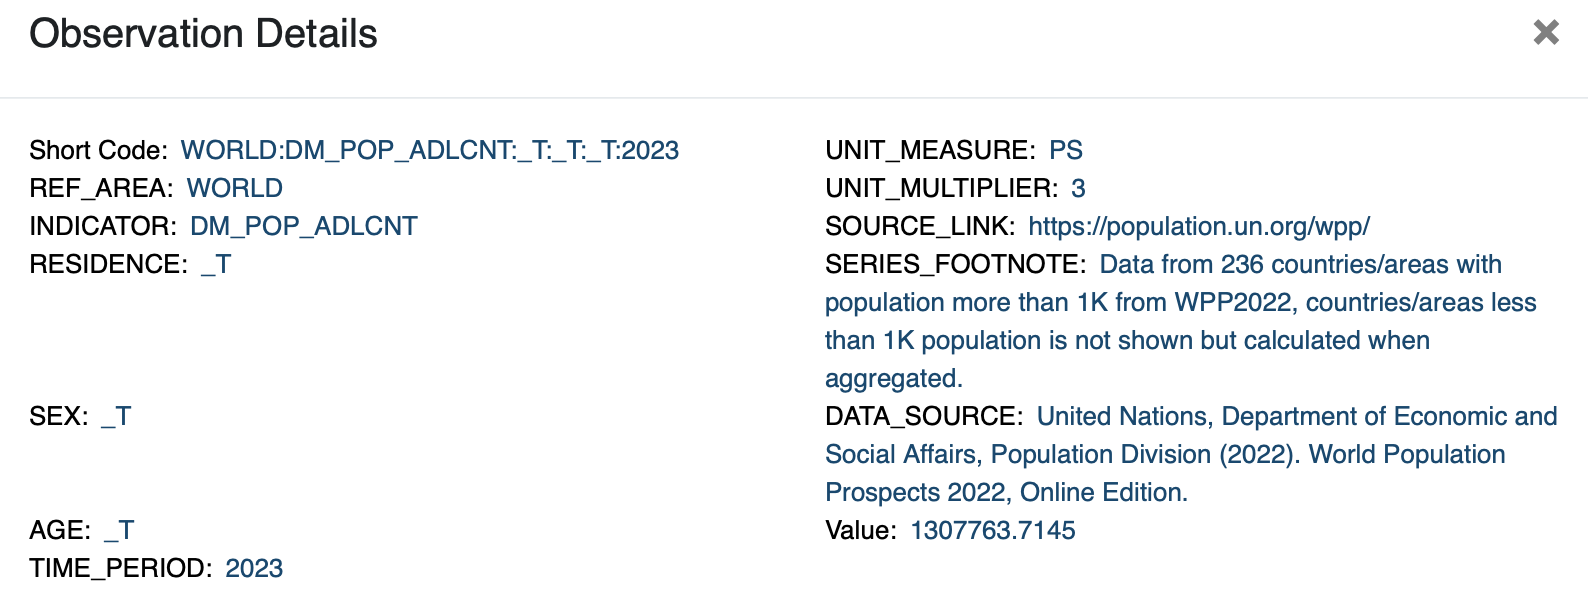


### **3. STEP: getting hold of the actual data**

To do this the following modified string has to be added to the endpoint. I also changed the format to CSV for further data exploration. 

It's possible to get just a slice of the data by specifying certain values for the dimensions.

- select **Western Europe** as reference area: ```UNICEF_WE```
- select **all residencies**: ```_T```
- select **all genders**: ```_T```
-

Those parameters have to be added to the endpoint string separated by dots. Multiple values for a dimensions should be separated by a "+". 

**Important**: The query string has to contain every dimension. If nothing should be specified is has to be expressed by a dot. The order is the same as the order in the dimensions list that was shown above. 

**REF_AREA.~~INDICATOR~~.RESIDENCE.SEX.~~AGE~~** -> **UNICEF_WE.._T._T.**

In [389]:
QUERY_STR = "UNICEF_WE.._T._T."

In [390]:
data_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/{QUERY_STR}"
data_params = {
    "format": "sdmx-json",
}

In [395]:
# get the response
data_response = requests.get(url=endpoint+data_endpoint, params=data_params).json()['data']

for list in data_response:
    print(list)

dataSets
structure


After retrieving the response in the JSON format, it's necessary to **connect the actual values with their corresponding dimensions and attributes**. Those are in separated in ```structure``` and ```dataSets```.